In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import shap
from sklearn.model_selection import ShuffleSplit
import seaborn as sns
# --- Load Data ---
file_path = Path(r"C:\Users\daddy\Downloads\6.+Turbofan+Engine+Degradation+Simulation+Data+Set\6. Turbofan Engine Degradation Simulation Data Set\CMAPSSData\train_FD001.txt")
columns = ["unit", "cycle"] + [f"setting_{i}" for i in range(1, 4)] + [f"sensor_{i}" for i in range(1, 22)]
df = pd.read_csv(file_path, sep="\s+", header=None, names=columns)

# --- Label (RUL) ---
df["max_cycle"] = df.groupby("unit")["cycle"].transform("max")
df["RUL"] = df["max_cycle"] - df["cycle"]
df.drop(columns=["max_cycle"], inplace=True)

# --- Normalized cycle ---
df["cycle_norm"] = df["cycle"] / df.groupby("unit")["cycle"].transform("max")

# --- Sensor Features ---
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]

for s in sensor_cols:
    df = df.copy()
    df[f"{s}_exp"]        = df.groupby("unit")[s].transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
    df[f"{s}_roll_mean"]  = df.groupby("unit")[s].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
    df[f"{s}_roll_std"]   = df.groupby("unit")[s].transform(lambda x: x.shift().rolling(window=5, min_periods=1).std().fillna(0))
    df[f"{s}_zscore"]     = (df[s] - df[f"{s}_roll_mean"]) / (df[f"{s}_roll_std"] + 1e-6)
    df[f"{s}_trend"]      = df.groupby("unit")[s].transform(lambda x: x.diff().fillna(0))
    df[f"{s}_dev"]        = df[s] - df.groupby("unit")[s].transform(lambda x: x.shift().expanding().mean())
    df[f"{s}_act"]        = df.groupby("unit")[s].transform(lambda x: x > x.shift().expanding().quantile(0.9)).astype(int)
    
    # --- Sensor reliability index: rolling std / mean ---
    df[f"{s}_rel_idx"]    = df[f"{s}_roll_std"] / (df[f"{s}_roll_mean"].abs() + 1e-6)
for s in sensor_cols:
    df[f"{s}_delta_start"] = df[s] - df.groupby("unit")[s].transform("first")
for s in sensor_cols:
    df[f"{s}_cum_trend"] = df.groupby("unit")[s].transform(lambda x: x.diff().fillna(0).cumsum())
zscore_cols = [f"{s}_zscore" for s in sensor_cols]
df["health_index"] = df[zscore_cols].mean(axis=1)
df = df.copy()
for s1, s2 in combinations(sensor_cols, 2):
    df = df.copy()
    df[f"{s1}_minus_{s2}"] = df[s1] - df[s2]
for s in sensor_cols:
    df[f"{s}_slope_5"] = df.groupby("unit")[s].transform(lambda x: x.rolling(window=5, min_periods=2).apply(lambda w: np.polyfit(range(len(w)), w, 1)[0], raw=True))
for s in sensor_cols:
    df[f"{s}_min_dev"] = df.groupby("unit")[s].transform("min") - df.groupby("unit")[s].transform("mean")
df["cycle_rev"] = df.groupby("unit")["cycle"].transform(lambda x: x.max() - x)
for s in sensor_cols:
    df[f"{s}_alarm_count"] = df.groupby("unit")[f"{s}_act"].transform("cumsum")
# --- Unit-level sensor normalization (per engine: mean/std) ---
for s in sensor_cols:
    unit_mean = df.groupby("unit")[s].transform("mean")
    unit_std = df.groupby("unit")[s].transform("std").replace(0, 1e-6)
    df[f"{s}_unitnorm"] = (df[s] - unit_mean) / unit_std

# --- Hybrid Loss Support: Binary failure threshold flag ---
df["is_soon_fail"] = (df["RUL"] < 50).astype(int)

# --- Final usable and cleaned dataframe ---
df_final = df.drop(columns=["unit", "cycle"])
df_clean = df_final.dropna(axis=0)
df_clean

C:\Users\daddy\anaconda3\envs\stonks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_13_unitnorm,sensor_14_unitnorm,sensor_15_unitnorm,sensor_16_unitnorm,sensor_17_unitnorm,sensor_18_unitnorm,sensor_19_unitnorm,sensor_20_unitnorm,sensor_21_unitnorm,is_soon_fail
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,-0.530578,0.463131,-0.139333,0.0,-0.578837,0.0,0.0,0.957781,1.115972,0
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,-1.050327,0.775905,-0.549594,0.0,-1.934162,0.0,0.0,0.658377,0.360510,0
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,-0.400640,0.883758,-2.003091,0.0,-0.578837,0.0,0.0,0.239211,0.643095,0
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,-0.920390,0.878365,-0.209664,0.0,0.098826,0.0,0.0,0.358973,0.933291,0
5,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,...,-1.050327,0.707598,-0.754725,0.0,-1.256499,0.0,0.0,0.838019,0.576492,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,2.474646,-1.544766,1.357177,0.0,2.443832,0.0,0.0,-1.580642,-2.876416,1
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,1.822135,-1.883679,1.877925,0.0,1.020931,0.0,0.0,-2.610553,-1.068515,1
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,2.148390,-0.481811,3.320655,0.0,3.155283,0.0,0.0,-1.851671,-3.267366,1
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,1.985263,-1.024072,2.589331,0.0,1.020931,0.0,0.0,-2.664759,-1.996292,1


--Data Loading

Data is read in via csv from the url via NASA of https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip

--Target Engineering
RUL is computed per engine unit using only information available at the end of that engine's life (the max cycle). It does not leak future failure information into the feature space seeing as it’s used only as a target. We then take the normalized function output of the max cycle as a feature. 

--Feature engineering
- s_exp = Exponential moving average (EMA) which smooths the sensor signal giving more weight to recent values making it good for catching fast changes in sensor behavior without overreacting to noise.
- s_roll_mean = a five step rolling average which tracks the average reading over the last few cycles to catch recent behavior and helps detect if the sensor reading is drifting steadily.
- s_rolling_std = a five step rolling standard deviation which measures the recent volatility of the sensor therefore rising std often means instability or mechanical degradation or can be thought of as so.
- s_zscore = a standard score based on rolling mean/std and measures how “unusual” the current sensor value is relative to its recent pattern which makes it great for anomaly detection.
- s_trend = a simple first order difference featurethat captures the direction of change such as rising, falling, or stable and it provides a signal for identifying degradation patterns.
- s_dev = a feature that shows the difference from the expanding mean which shows whether the sensor is above or below its historical average and gives insight into whether the engine is slowly worsening.
- s_act = a boolean flag for high sensor activation which helps us indicates whether the sensor reading is in the top 10% of its historical values acting as a proxy for “warning” or “alert” behavior.
- s_rel_idx = a simple reliability index consisting of the rolling std / the rolling mean where the high value means the sensor is unstable relative to its magnitude and can flag erratic behavior.
- s_delta_start = a feature that shows the difference from the starting value which tracks how far the sensor has drifted from its baseline and helps estimate wear and tear relative to the engine's original state.
- s_cum_trend = a cumulative sum of first differences that measure total trend progression over time which can help represent total wear buildup.
- s_slope_5 = The linear slope of the last 5 samples which quantifies how fast the sensor is trending up or down to give a sense of acceleration.
- health_index = the mean of all the zscores which makes it a composite indicator of overall anomaly level similar to that of the heartbeat of the engine across all sensors.
- s1_minus_s2 = The sensor pair differences which captures relationships between sensors, because it's possible for failures to not simply show up in just one sensor but in how they diverge together.
- s_min_dev = The minimum value minus the mean which measures how deep the sensor ever dropped compared to normal making it useful for detecting past anomalies or drops.
- cycle_rev = The reverse cycle index represents how far from failure the engine is
- s_alarm_count = The cumulative sum of s_act which tells us how often that sensor has gone into a “warning” state which gives us more insight into  long-term degradation patterns.
- s_unitnorm = a feature that normalizes the sensor value per engine which makes sensor values comparable across different engines and helps cancel out fixed differences between engines.
- is_soon_fail = a classification feature representing a red zone in degradation build up.
--Output DataFrame
- the output dataframe is then made to drop the unit and cycle columns, and any rows with NaN's in them. 

In [2]:
# - Silence pandas warnings for speed -
pd.options.mode.chained_assignment = None

# - Defining X and Y -
X = df_clean.drop(columns=["RUL"])
y = df_clean["RUL"]

# - Splitting the training (seen) data and testing (unseen) data -
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, shuffle=True, random_state=42)

# - Defining the Self Reinforcing Critic Network -
class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# - Self Reinforcing Training Loop -
for cycle in range(3):
    print(f"\n🌀 Self-Reinforcement Cycle {cycle + 1}")

    # Drop previous correction column if exists
    for df in [X_train, X_test]:
        if "critic_correction" in df.columns:
            df.drop(columns=["critic_correction"], inplace=True)

    # Fitting the base model
    booster = xgb.XGBRegressor(
        n_estimators=250,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )
    booster.fit(X_train, y_train)

    # Calculating residuals
    y_pred_train = booster.predict(X_train)
    residuals = y_train.values - y_pred_train

    # Cleaning the residuals in case any NaNs slipped
    mask = ~np.isnan(residuals)
    X_train_cleaned = X_train.iloc[mask].copy()
    residuals_cleaned = residuals[mask]
    
    # Training the Self Reinforced critic
    critic = Critic(X_train_cleaned.shape[1])
    optimizer = optim.Adam(critic.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    X_tensor = torch.tensor(X_train_cleaned.values, dtype=torch.float32)
    y_tensor = torch.tensor(residuals_cleaned.reshape(-1, 1), dtype=torch.float32)

    for epoch in range(10):
        critic.train()
        optimizer.zero_grad()
        pred = critic(X_tensor)
        loss = criterion(pred, y_tensor)
        loss.backward()
        optimizer.step()

    # Applying the critic
    critic.eval()
    with torch.no_grad():
        corr_train = critic(torch.tensor(X_train.values, dtype=torch.float32)).numpy().flatten()
        corr_test = critic(torch.tensor(X_test.values, dtype=torch.float32)).numpy().flatten()

    if np.isnan(corr_train).any() or np.isnan(corr_test).any():
        raise ValueError("NaNs found in critic output despite cleanup")

    X_train["critic_correction"] = corr_train
    X_test["critic_correction"] = corr_test

    # Saving both the critic weights and input dimensions
    torch.save({
        'model_state_dict': critic.state_dict(),
        'input_dim': X_train.shape[1]
    }, "critic_cycle_latest.pt")

    print(f"✅ Cycle {cycle+1} complete. NaNs in X_train: {X_train.isna().sum().sum()}, X_test: {X_test.isna().sum().sum()}")

# - Final Critic Application to ensure the safe reloading of the input dimensions -
X_test_base = X_test.drop(columns=["critic_correction"])
input_dim = X_test_base.shape[1]

checkpoint = torch.load("critic_cycle_latest.pt", weights_only=True)
critic = Critic(input_dim)
critic.load_state_dict(checkpoint['model_state_dict'])
critic.eval()

with torch.no_grad():
    corr_final = critic(torch.tensor(X_test_base.values, dtype=torch.float32)).numpy().flatten()

X_test_aug = X_test_base.copy()
X_test_aug["critic_correction"] = corr_final

# - Final Model Training -
final_model = xgb.XGBRegressor(
    n_estimators=250,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test_aug)

# - Final Metrics -
true = y_test.to_numpy().flatten()
pred = final_pred.flatten()
non_zero_idx = true != 0

print({
    "Final MAE": mean_absolute_error(true, pred),
    "Final RMSE": mean_squared_error(true, pred),
    "Final R2": r2_score(true, pred),
    "Final MAPE": np.mean(np.abs((true[non_zero_idx] - pred[non_zero_idx]) / true[non_zero_idx])) * 100
})


🌀 Self-Reinforcement Cycle 1
✅ Cycle 1 complete. NaNs in X_train: 0, X_test: 0

🌀 Self-Reinforcement Cycle 2
✅ Cycle 2 complete. NaNs in X_train: 0, X_test: 0

🌀 Self-Reinforcement Cycle 3
✅ Cycle 3 complete. NaNs in X_train: 0, X_test: 0
{'Final MAE': 0.3429773151874542, 'Final RMSE': 0.3611445426940918, 'Final R2': 0.9999204277992249, 'Final MAPE': np.float64(0.39341750750532783)}


--Model Overview

- The model utilizes every feature and stores them inside X which it then uses for training excluding the target RUL which it stores in Y meaning our target is how many cycles the engine has left before failure.
-  We then Randomly split our dataset into 80% training data (the data the model sees) and 20% test data (unseen data).
-  Next we design a class to store a small and simplistic 3-layer feedforward residual neural network of 128 by 64 by 1
-  We then proceed to devise a 3 cycle self reinforcement for-loop where each cycle tries to improve the base xgboost model by adding a learned correction from the Critic.
-  We then train an xgboost model on the current training set which is our main RUL predictor.
-  We then calculate the residuals which is used to get the past error data (true RUL - predicted RUL) which is what the self reinforcement Critic learns to fix.
-  We then train the critic on the residuals at which point the critic learns a mapping from input features to the residual error. This teaches it how to nudge in a way so that the model’s ability to predict toward the ground truth is relatively superior.
-  We then apply the critic correction so that the critic knows where the model usually goes wrong which we then add as a new feature for the base model.
-  We then reload the last critic we trained while ensuring we maintain its structure
-  We then apply the reloaded structure to X_Test again to adjust our already produced predictions.
-  We then train the final XGBoost model using the critic corrected training data and then make predictions on the test set with the critic corrections factored in.
-  Finally we calculate mean absolute error, mean squared error, r-squared or variance explained and then mean absolute percentage error. 

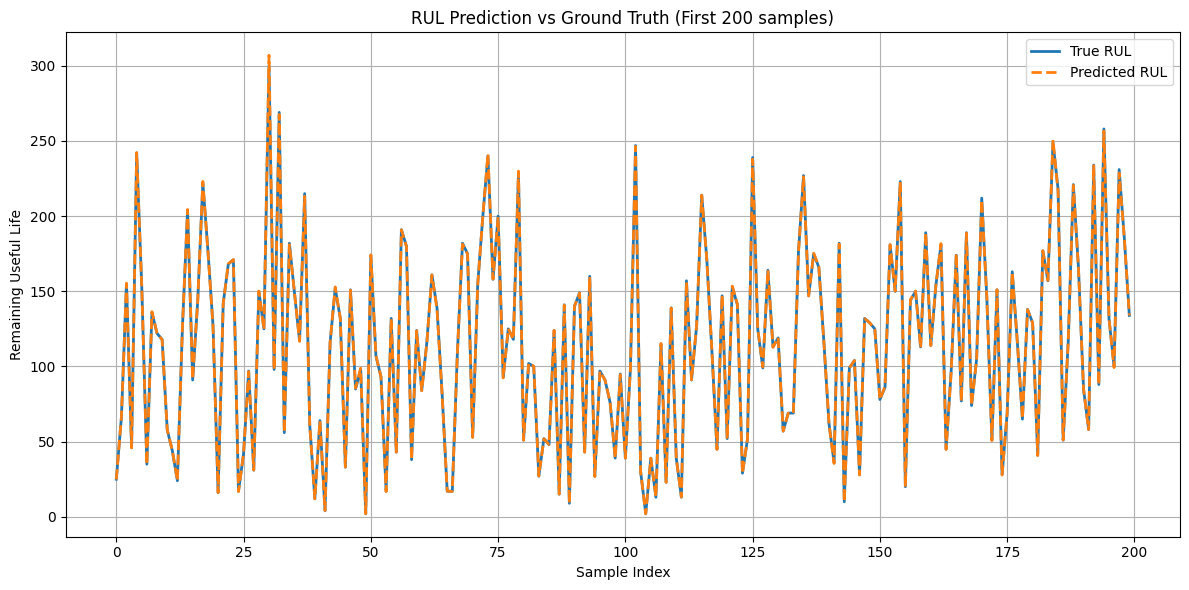

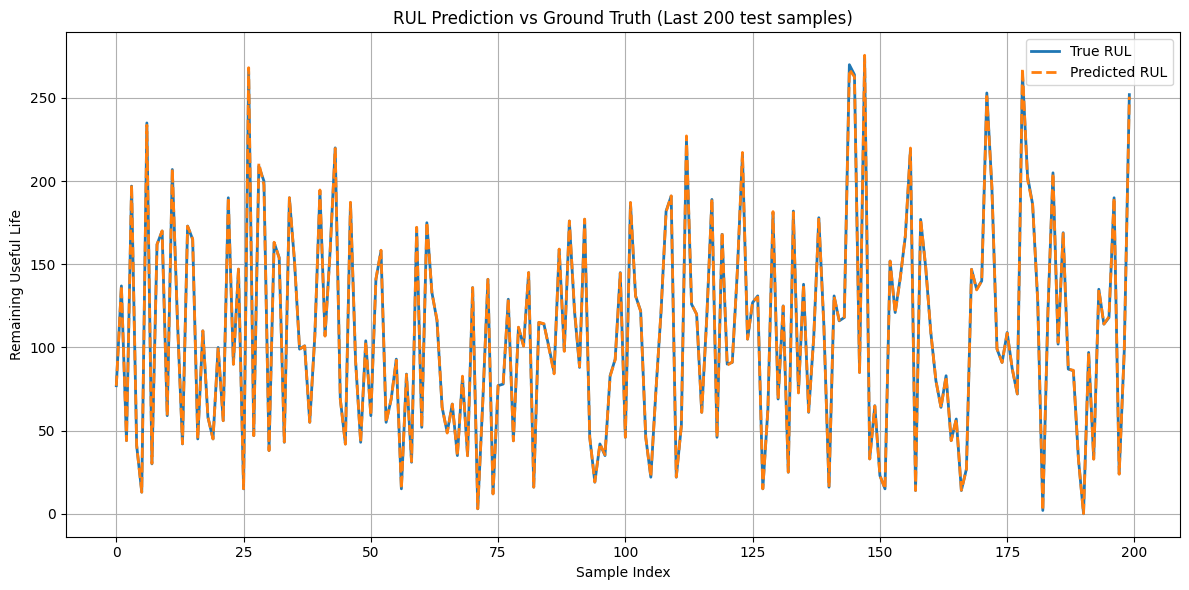

In [3]:
# - First 200 true vs predicted RUL samples -
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label="True RUL", linestyle='-', linewidth=2)
plt.plot(final_pred[:200], label="Predicted RUL", linestyle='--', linewidth=2)
plt.title("RUL Prediction vs Ground Truth (First 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# - Last 200 true vs predicted RUL samples -
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-200:], label="True RUL", linestyle='-', linewidth=2)
plt.plot(final_pred[-200:], label="Predicted RUL", linestyle='--', linewidth=2)
plt.title("RUL Prediction vs Ground Truth (Last 200 test samples)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

-Figures 1 and 2

- Purely for visualization and comparison of the first 200 sample predictions during training vs the last 200 sample predictions during testing.

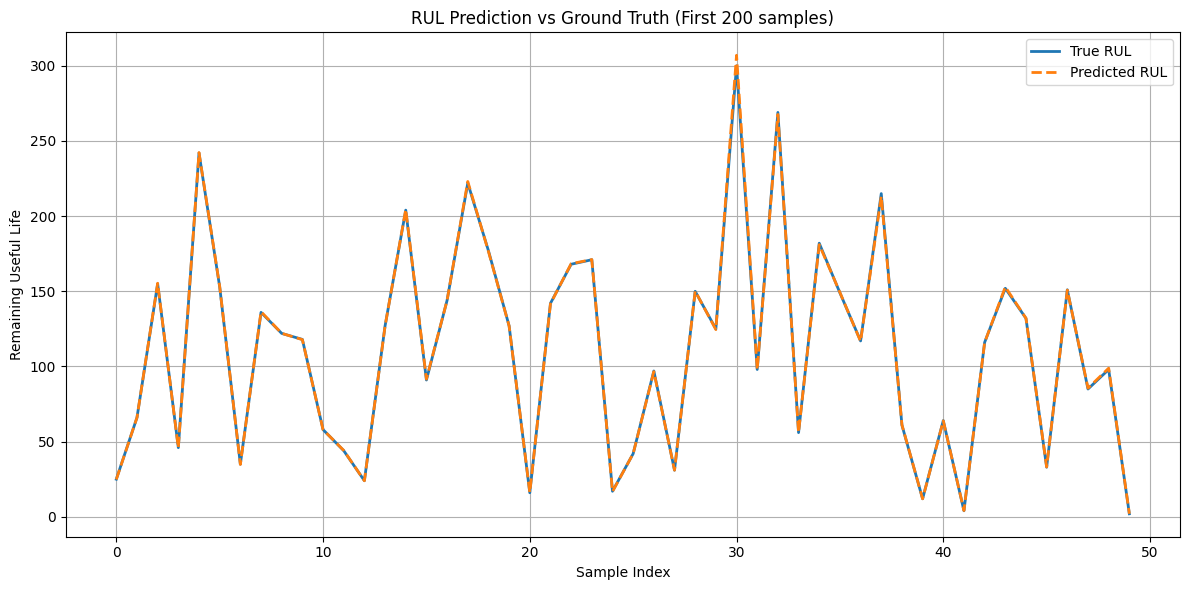

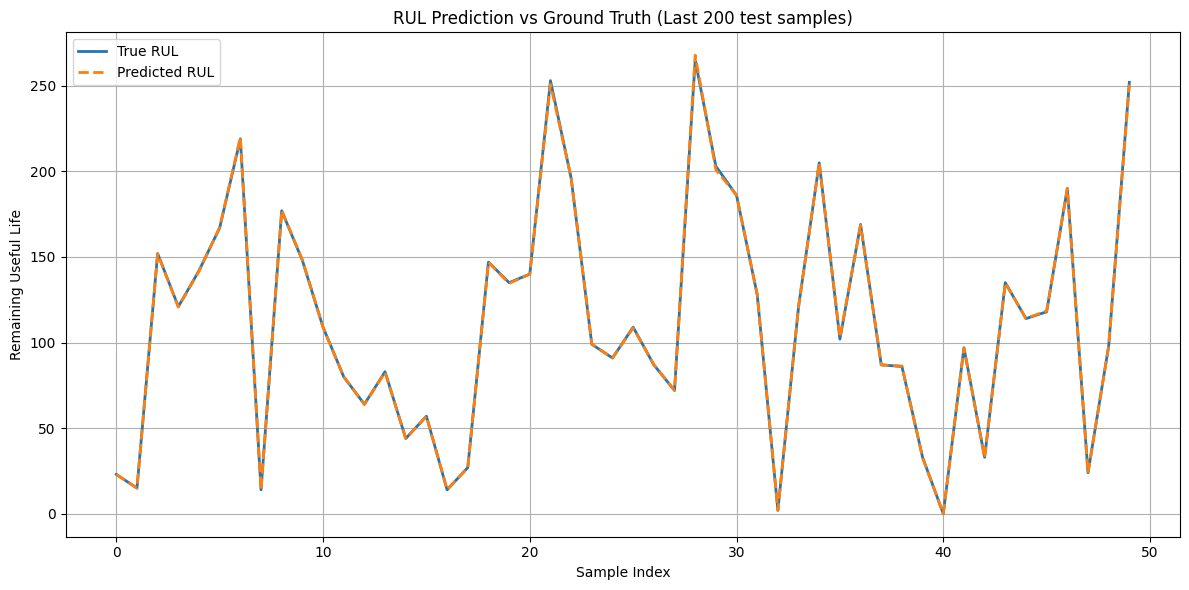

In [4]:
# - First 200 true vs predicted RUL samples -
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label="True RUL", linestyle='-', linewidth=2)
plt.plot(final_pred[:50], label="Predicted RUL", linestyle='--', linewidth=2)
plt.title("RUL Prediction vs Ground Truth (First 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# - Last 200 true vs predicted RUL samples - 
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-50:], label="True RUL", linestyle='-', linewidth=2)
plt.plot(final_pred[-50:], label="Predicted RUL", linestyle='--', linewidth=2)
plt.title("RUL Prediction vs Ground Truth (Last 200 test samples)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

-Figures 3 and 4

- Also, purely for visualization and comparison of the first 50 sample predictions during training vs the last 50 sample predictions during testing.

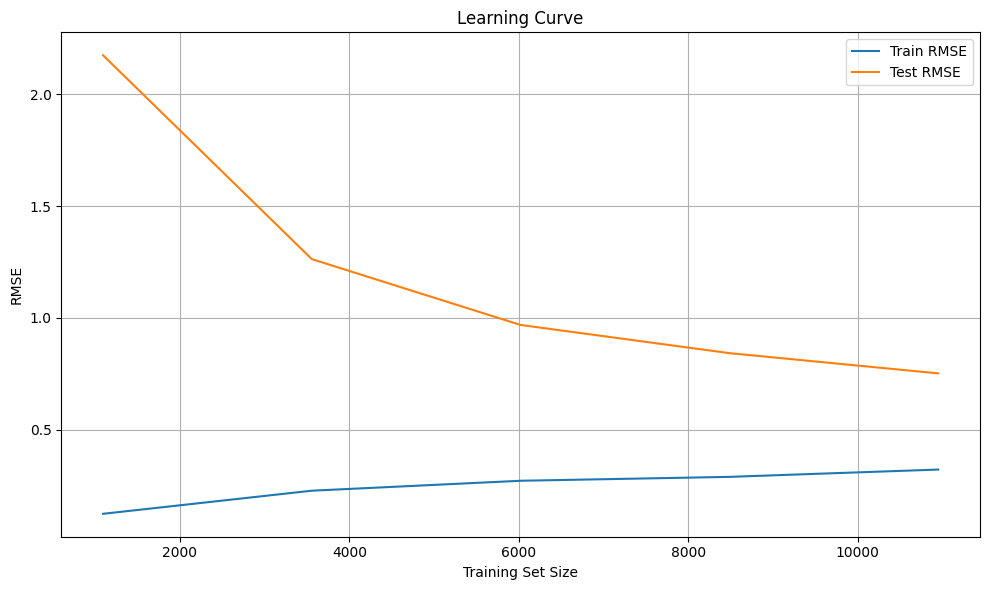

-0.9863160848617554

In [5]:
# - Learning Curve -
train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    cv=3,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
test_rmse = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Train RMSE')
plt.plot(train_sizes, test_rmse, label='Test RMSE')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# - Permutation Test for Generalization -
y_test_permuted = np.random.permutation(y_test)
perm_pred = final_model.predict(X_test_aug)
perm_r2 = r2_score(y_test_permuted, perm_pred)

perm_r2

-Figure 5

- Consists of a visualization of the Learning curves over the course of both the training and testing sessions. 

--Learning Curve Analysis

- We see that the testing RMSE decreases overtime as the data size grows while training RMSE slightly increases as 
the data size grows suggesting good model generalization while also suggesting we're not overfitting as can be seen clearly in Figures 3 and 4,

- We then observe that training RMSE is low and increasing gradually which is expected because as the training size increases, the model sees more variation and generalizes better, but it's slightly harder to fit perfectly therefore RMSE should be slightly increasing overtime. Which it is.  

- We also see a small gap between training and testing that continues to shrink as the data size grows larger suggesting we're not underfitting as well and confirms improving generalization of the model as it is exposed to more data but with zero signs of divergence which would indicate overfitting as well as no sign of flattening toward higher RMSE'S which would also indicate overfitting. 

- Permutation Score ≈ -0.98
A result of -0.98 for PS implies the model’s predictions are extremely informative and not random at all. 

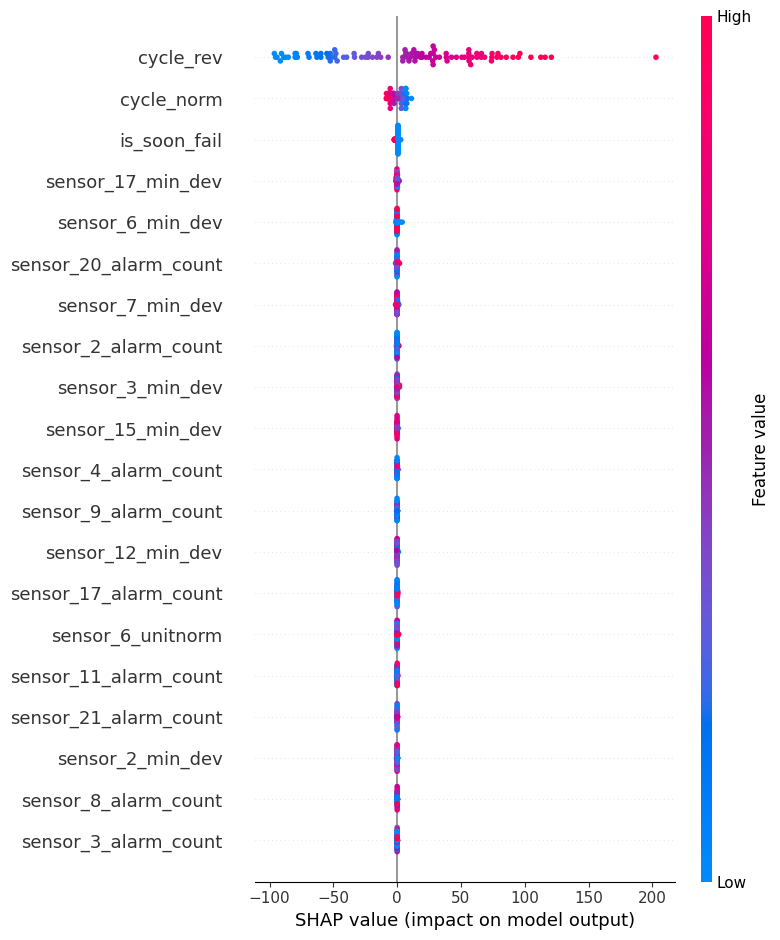

In [6]:
# - Sampling for SHAP -
X_shap_sample = X_test_aug.sample(n=100, random_state=42)

# - SHAP explainer and their values -
explainer = shap.Explainer(final_model)
shap_values = explainer(X_shap_sample)

# - SHAP Summary Plot -
shap.summary_plot(shap_values, X_shap_sample)

Monte Carlo CV RMSE (mean ± std): 0.3129454642534256 ± 0.02738963524240995


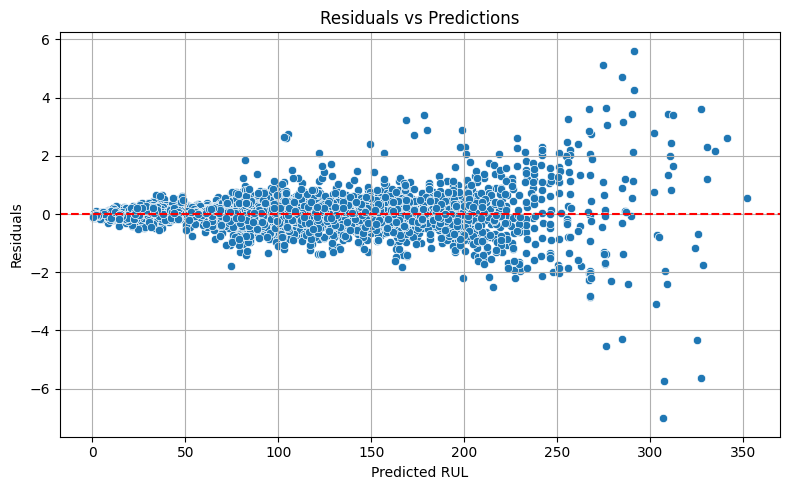

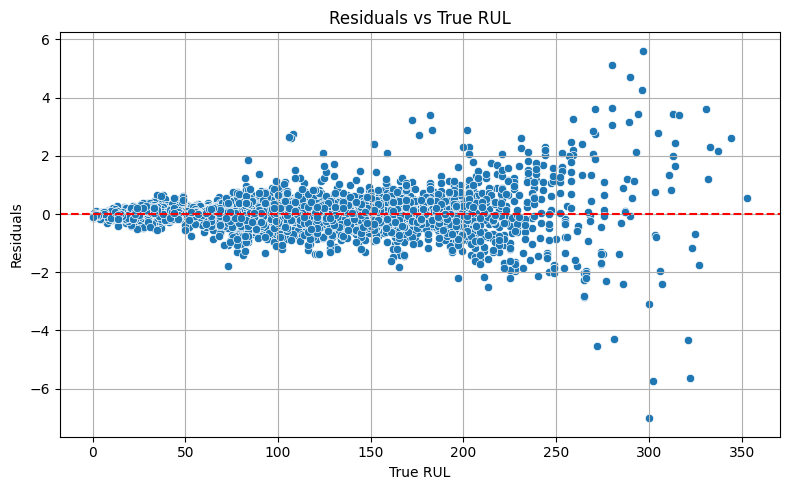

In [7]:
# - Monte Carlo CV test -
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv_rmse_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
    y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model_cv = xgb.XGBRegressor(
        n_estimators=250,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_cv_train, y_cv_train)
    y_cv_pred = model_cv.predict(X_cv_test)
    
    rmse = mean_squared_error(y_cv_test, y_cv_pred)
    cv_rmse_scores.append(rmse)

print("Monte Carlo CV RMSE (mean ± std):", np.mean(cv_rmse_scores), "±", np.std(cv_rmse_scores))


residuals = y_test.values.flatten() - final_pred.flatten()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=final_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted RUL")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs True RUL")
plt.xlabel("True RUL")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

--SHAP Summary Interpretation
Our top features are cycle_rev, cycle_norm, is_soon_fail, sensor_X_min_dev, and critic_correction.

- This aligns with RUL degradation theory which suggests engines nearing failure should show signals in cycle-based metrics and deviations from early states. Showing the model has indeed learned and understood this vital concept.

- SHAP shows no single dominating feature while also suggesting the model is relying on a healthy mixture which has contributed greatly to good generalization and preventing overfitting on a few spurious signals.

-- Residual Diagnostics

- There is no clear bias in the predictions (not always underpredicting or overpredicting). Variance explained is incredibly strong as shown in the two figures.

- Which is reinforced by the fact that variance does increase overtime which suggests based upon earlier observations in figures 1,2,3, and 4 of absolute training and testing prediction results, we are experiencing minor underfitting for long-life engines. Which is actually preferable in real world applications in terms of safety.

--Monte Carlo Cross-Validation (Text Result)

- RMSE mean ± std = 0.3129 ± 0.0273: tight variance across random splits.

- This implies that the model has learned to generalize unto unseen units despite varying operational conditions. Which proves adaptability. 